# Spectral Subgraph Localization

**Author**: Amit Boyarski & Judith Hermanns

## Intro

We are interested in solving the problem of **subgraph localization**:

Given a full graph $\mathcal{G}$ and a subgraph $\mathcal{H}$, find a subgraph (i.e., a set of nodes and edges) within $\mathcal{G}$ that matches $\mathcal{H}$ as close as possible.

The desired output is a scalar field over $\mathcal{G}$ denoting the probabilities of each node and edge belonging to $\mathcal{H}$. Note that this is a superficially simpler problem than finding full point-to-point correspondence between $\mathcal{H}$ and $\mathcal{G}$.

We approach the problem by modeling it as an optimization problem over $\mathcal{G}$. Let use denote by $\mathbf{v} : \mathcal{N}\rightarrow \mathbb{R}^{\mathcal{N}}$ and $\mathbf{E}: {\mathcal{N} \times \mathcal{N}}\rightarrow \mathbb{R}^{\mathcal{N} \times \mathcal{N}}$ two potential fields (i.e., "masks") over the nodes and edges of $\mathcal{G}$. We shall denote the Laplacian of $\mathcal{G}$ by $\mathbf{L} = \mathbf{D}-\mathbf{A}$, where $\mathbf{A}$ is the adjacency matrix, and $\mathbf{D}\equiv \textbf{diag}(\mathbf{A}\mathbf{1})$ is the degree matrix of $\mathcal{G}$.

The edge potential $\mathbf{E}$ is used to detach the subgraph from the full graph, i.e., by demanding $\mathbf{L}_E \equiv \mathbf{L}-\mathbf{E}$ to be a Laplacian of a graph composed of two disconnected components (one of which corresponds to $\mathcal{H}$). Once the subgraph has been detached, we use the node potential $\mathbf{v}$ to modify the spectrum of the edited Laplacian $\mathbf{L}_E$ such that it should match the spectrum of the Laplacian of $\mathcal{H}$, denoted hereby by $\mathbf{\lambda}_{ref}$.

To that end, our optimization problem is composed of a data term and regularization terms:


$$
\min_{\mathbf{E},\mathbf{v}} \mu_{spect}\|\mathbf{\lambda}(\mathbf{L}-\mathbf{E}+\text{diag}(\mathbf{v})) - \mathbf{\lambda}_{ref}\|^2 +
 \mu \mathbf{v}^T\bigl( \mathbf{L}-\mathbf{E}\bigr) \mathbf{v}
$$
$$
\text{s.t.}\;\;\|\mathbf{v}\| = \text{const}, \mathbf{E}=\mathbf{E}^\top,\mathbf{E}\mathbf{1}=\mathbf{0},\;\text{offdiag}(\mathbf{L}-\mathbf{E})\leq 0,\;\text{tr}(\mathbf{E}) \leq k
$$


- The first term (spectral alignment term) is supposed to align the spectra of the localized subgraph with that of the reference subgraph $\mathcal{H}$.
- The second term is in order to make sure that $\mathbf{v}$ is piecewise constant, i.e., it should equal $\infty$ (or some large number, larger than the maximum eugenvalue in $\mathbf{\lambda}_{ref}$) outside our subgraph, and $0$ on the subgraph. Alternatively, it pushes $\mathbf{v}$ into the nullspace of the edited Laplacian.
- The constraints on $\mathbf{E}$ ensure that $\mathbf{L}_E$ is a valid Laplacian, and that the number of edited edges is bounded by $k$.
- The sphere constraint $\|\mathbf{v}\| = \text{const}$ fixes the norm of $\mathbf{v}$, restricting the solution space to that of the ideal potential. The $\text{const}$ can be computed from the spectrum of the subgraph. From a numerical perspective, normalizing $\mathbf{v}$ after every iteration is reminiscent of the power iteration, promoting  $\mathbf{v}$ to converge to the Fiedler vector of $\mathbf{L}-\mathbf{E}$.

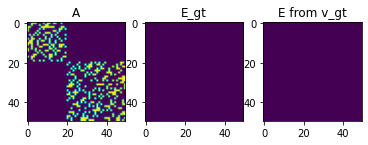

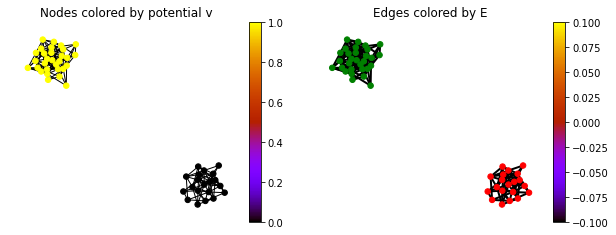

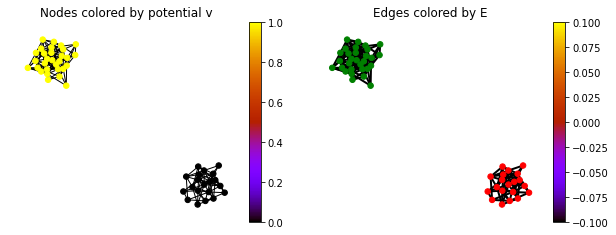

In [11]:
from problem.base import lap_from_adj, block_stochastic_graph, E_from_v, plot_on_graph
from data.data_loaders import load_data
import kmeans1d as kmeans1d

from optimization.prox.prox import ProxNonNeg, ProxL21ForSymmCentdMatrixAndInequality, ProxL1ForSymmCentdMatrixAndInequality

from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from problem.spectral_subgraph_localization import ProximalSubgraphIsomorphismSolver
import os

#torch.manual_seed(12)
#torch.manual_seed(0)
data_type = 'synthetic' # 'synthetic', 'real'
if data_type == 'synthetic':

    sizes = [20, 30]
    probs = 0.3 * np.eye(len(sizes))
    for i in range(probs.shape[0]):
        for j in range(probs.shape[1]):
            if i != j:
                probs[i, j] = 0.0001
    probs = probs.tolist()
    G = nx.stochastic_block_model(sizes, probs, seed=42)
    A = torch.tensor(nx.to_numpy_matrix(G))
    n1 = sizes[0]
    n = np.sum(sizes)

    A_sub = A[0:n1, 0:n1]
    ref_spectrum = torch.linalg.eigvalsh(lap_from_adj(A_sub))

    v_val = float(np.max(ref_spectrum.numpy()))
    c = np.sqrt(n-n1) * v_val
    v_gt = v_val * np.ones(n)
    v_gt[0:n1] = 0.0
    gt_inidicator = np.copy(v_gt)
    gt_inidicator[gt_inidicator>0]=1
    A_edit = torch.zeros_like(A)
    A_edit[0:n1, n1:n] = -A[0:n1, n1:n]
    A_edit[n1:n, 0:n1] = -A[n1:n, 0:n1]
    E_gt = lap_from_adj(A_edit)
    E_from_v_tensor,_  = E_from_v(torch.tensor(v_gt), A)

elif data_type=='real':
    benchmark = 'stochastic_block_model' # 'SI_survey'
    target = os.getcwd() + '/../data/newSIPbenchmarks/images-CVIU11/targets/target1'
    pattern =  os.getcwd() + '/../data/newSIPbenchmarks/images-CVIU11/patterns/pattern1'
    A,A_sub = load_data(target = target, pattern = pattern)
    n = A.shape[0]
    n1 = A_sub.shape[0]
    ref_spectrum = torch.linalg.eigvalsh(lap_from_adj(A_sub))
    v_val = float(np.max(ref_spectrum.numpy()))
    c = np.sqrt(n-n1) * v_val
    v_gt = None
    E_from_v_tensor  = None

gt_inidicator = v_gt
gt_inidicator[gt_inidicator>0]=1

fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flat
axes[0].imshow(A)
axes[0].set_title('A')
axes[1].imshow(E_gt)
axes[1].set_title('E_gt')
axes[2].imshow(E_from_v_tensor)
axes[2].set_title('E from v_gt')
plt.show()


pos = nx.spring_layout(G)
plot_on_graph(
    A=A.numpy().astype(int),
    v=v_gt,
    E=E_gt.numpy().astype(int),
    subset_nodes=range(n1),
    pos = pos
    )

plot_on_graph(
    A=A.numpy().astype(int),
    v=v_gt,
    E=E_from_v_tensor.numpy().astype(int),
    subset_nodes=range(n1),
    pos = pos
    )

In [12]:
from optimization.prox.prox import ProxId, ProxSphere, ProxL21ForSymmetricCenteredMatrix

problem_params = {'mu_spectral': 1,
                  'mu_l21': 0,
                  'mu_MS': 0,
                  'mu_split': 0,
                  'mu_trace': 0.0,
                  'trace_val': 0,
                  'weighted_flag': False
                  }
solver_params = {'lr': 0.02,
                 'a_tol': -1,
                 'r_tol': -1e-5/c**2, # not used
                 'v_prox': ProxSphere(radius=c),
                 #'v_prox': ProxId(),
                 'E_prox': ProxL21ForSymmetricCenteredMatrix(solver="cvx"),
                 # 'E_prox': ProxL1ForSymmCentdMatrixAndInequality(solver="cvx", L=L,
                 #                                                 trace_upper_bound=
                 #                                                 1.1 * torch.trace(L)),}
                 'train_v': True,
                 'train_E': False,
                 'threshold_algo': 'spectral', # 'spectral', '1dkmeans', 'smallest'
                 }
subgraph_isomorphism_solver = ProximalSubgraphIsomorphismSolver(A, ref_spectrum, problem_params, solver_params)

init_type_E = 'default' # 'gt, 'noisy', 'default'
init_type_v = 'default' # 'gt, 'noisy', 'default'

if init_type_E == 'gt':
    subgraph_isomorphism_solver.set_init(E0=torch.tensor(E_gt),
                                         v0 =subgraph_isomorphism_solver.v)

if init_type_v == 'gt':
    subgraph_isomorphism_solver.set_init(v0 = torch.tensor(v_gt),
                                         E0 = subgraph_isomorphism_solver.E)
elif init_type_v == 'noisy':
    subgraph_isomorphism_solver.set_init(
        v0 = torch.tensor(v_gt+0.5*c*np.random.randn(v_gt.shape[0])))


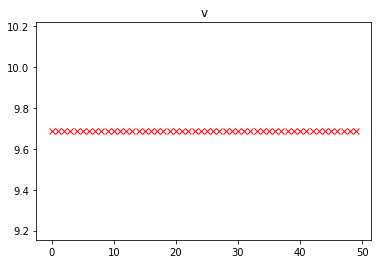

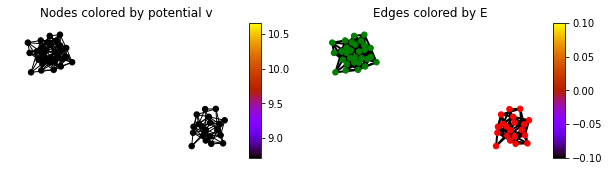

ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

In [13]:
from sklearn.metrics import accuracy_score
# plot init
from metrics.evaluation_metrics import MetricEvaluator
metric_keys = ["accuracy", "balanced_accuracy", "jaccard_score"]

v0 = subgraph_isomorphism_solver.v
E0 = subgraph_isomorphism_solver.E
plots = {
    'full_loss': False,
    'E': False,
    'v': True,
    'diag(v)': False,
    'v_otsu': False,
    'v_kmeans': False,
    'A edited': False,
    'L+E': False,
    'ref spect vs spect': False,
    'individual loss terms': False}

subgraph_isomorphism_solver.plot(plots)
plot_on_graph(
    A=A.numpy().astype(int),
    v=v0.detach().numpy(),
    E=E0.detach().numpy(),
    subset_nodes=range(n1))
metric_evaluator = MetricEvaluator(A = A, subgraph_size=n1)

#v_clustered = v0.detach().numpy()/ np.max(v0.detach().numpy())
v_clustered, E_clustered = \
    subgraph_isomorphism_solver.threshold(v_np = v0.detach().numpy(),threshold_algo=solver_params['threshold_algo'])
metrics = [metric_evaluator.evaluate(v_np = v_clustered.detach().numpy(),v_gt = gt_inidicator)]
metric_evaluator.print(metrics, keys=metric_keys)

In [14]:
from tqdm import tqdm
from matplotlib.pyplot import pause
import warnings
warnings.filterwarnings('ignore')

plots = {
    'full_loss': False,
    'E': False,
    'v': True,
    'diag(v)': False,
    'v_otsu': False,
    'v_kmeans': False,
    'A edited': False,
    'L+E': False,
    'ref spect vs spect': True,
    'individual loss terms': False}
v_acc_list = []
E_acc_list = []
v_balanced_acc_list = []
E_balanced_acc_list = []
metrics = []

mu_MS_list = np.linspace(1,1,1)
threshold_E = False
for iter, mu_MS in enumerate(mu_MS_list):
    print(f"iter = {iter}")
    pause(1)
    problem_params = {'mu_spectral': 1,
                      'mu_l21': 0,
                      'mu_MS': mu_MS / (c ** 2),
                      'mu_split': 0,
                      'mu_trace': 0.0,
                      'trace_val': 0,
                      'weighted_flag': False
                      }
    subgraph_isomorphism_solver.set_problem_params(problem_params)

    V = torch.eye(A.shape[0]).double()
    L = lap_from_adj(A)
    v_gt_tensor = torch.tensor(v_gt)
    v_gt_tensor = v_gt_tensor/torch.norm(v_gt_tensor)
    v = v_gt_tensor ##### initializing with gt for test
    k = ref_spectrum.shape[0]
    for outer_iter in range(10):
        print(f"{outer_iter=}")
        shift_matrix = c* torch.diag(1- v/v.max())
        # expand the matrix to size n by n using torch.zeros()
        mat = torch.zeros(n, n)
        perturbed_spectrum = ref_spectrum + 0e-8*torch.randn(ref_spectrum.shape)
        mat[:k, :k] = torch.diag(perturbed_spectrum,diagonal=0)
        shifted_L = L # - mat
        LU, pivots = torch.lu(shifted_L + shift_matrix)
        P, Lt, Ut = torch.lu_unpack(LU, pivots)

        # tests:
        shifted_evals = torch.linalg.eigh(shifted_L+shift_matrix)[0][:n1]

        for inner_iter in range(10):
            smallest_eval = V[:, 0].T @ (L + shift_matrix) @ V[:, 0]
            print(f"v'(L+shift(v))v = {smallest_eval}")
            Y = torch.linalg.solve(Lt, P.T@V)
            Z = torch.linalg.solve(Ut, Y)
            V,_ = torch.linalg.qr(Z)

        v = V[:,0]
        E,_  = E_from_v(v.detach(), A)

    pause(1)
    v_binary, E_binary = subgraph_isomorphism_solver.threshold(v_np=v.detach().numpy(), threshold_algo=solver_params['threshold_algo'])
    loss = subgraph_isomorphism_solver.smooth_loss_function(ref_spectrum, lap_from_adj(A), torch.tensor(E_binary), torch.tensor(c*v_binary))
    #subgraph_isomorphism_solver.plot(plots)
    plot_on_graph(A=A.numpy().astype(int),
                  v=v.detach().numpy(),
                  E=E.detach().numpy(),
                  subset_nodes=range(n1))

    v_clustered, E_clustered = \
            subgraph_isomorphism_solver.threshold(v_np = v.detach().numpy(),threshold_algo=solver_params['threshold_algo'])
    metrics.append(metric_evaluator.evaluate(v_np = v_clustered.detach().numpy(), v_gt = gt_inidicator))

    if threshold_E:
        v_clustered, E_clustered = \
            subgraph_isomorphism_solver.threshold(v_np = v.detach().numpy(),threshold_algo=solver_params['threshold_algo'])
        subgraph_isomorphism_solver.set_init(E0 = E_clustered, v0 = v)

iter = 0
outer_iter=0


KeyboardInterrupt: 

In [6]:
print(f"total loss:{subgraph_isomorphism_solver.loss_vals[-1]}")
print(f"spectral alignment loss:{subgraph_isomorphism_solver.spectrum_alignment_terms[-1]}")
print(f"MS loss:{subgraph_isomorphism_solver.MS_reg_terms[-1]}")
l = subgraph_isomorphism_solver.spectrum_alignment_loss(ref_spectrum,lap_from_adj(A),subgraph_isomorphism_solver.E, subgraph_isomorphism_solver.v)
print(' ')

metric_evaluator.print(metrics, keys=metric_keys)


IndexError: list index out of range

In [ ]:
from problem.base import indicator_from_v, plot_on_graph
import kmeans1d

plots = {
    'full_loss': False,
    'E': False,
    'v': True,
    'diag(v)': False,
    'v_otsu': False,
    'v_kmeans': False,
    'A edited': False,
    'L+E': False,
    'ref spect vs spect': True,
    'individual loss terms': True}

v_np = v.detach().numpy()
E_np = E.detach().numpy()
v_indicator = indicator_from_v(v.detach()).numpy()
v_clustered, E_clustered = subgraph_isomorphism_solver.threshold(
    v_np=v_indicator, threshold_algo=solver_params['threshold_algo'])
subgraph_isomorphism_solver.plot(plots)
plot_on_graph(A=A.numpy().astype(int),
              v=v_indicator,
              E=E_np,
              subset_nodes=range(n1))

plot_on_graph(A=A.numpy().astype(int),
              v=v_clustered.numpy(),
              E=E_clustered.numpy(),
              subset_nodes=range(n1))